In [1]:
import tensorflow as tf

In [2]:
import numpy
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
from pathlib import Path

In [4]:
def check_extension(img_path:str) -> bool:
    valid = False
    ext = img_path.split('.')[-1]
    if ext in ['jpg', 'jpeg', 'bmp', 'png', 'JPG', 'PNG', 'JPEG', 'BMP']:
        valid = True
    return valid

In [5]:
DATA_DIR = Path('potato')

In [6]:
for img_cls in os.listdir(DATA_DIR):
    for img in os.listdir(os.path.join(DATA_DIR, Path(img_cls))):
        img_path = os.path.join(DATA_DIR, Path(img_cls), Path(img))
        try:
            img = cv2.imread(img_path)
            if not check_extension(img_path):
                print(f'Image not in expected format: {img_path}')
                os.remove(Path(img_path))
        except Exception as e:
            print(f'Issue with image: {img_path}')

In [7]:
data = tf.keras.utils.image_dataset_from_directory(DATA_DIR)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = data.class_names

In [9]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

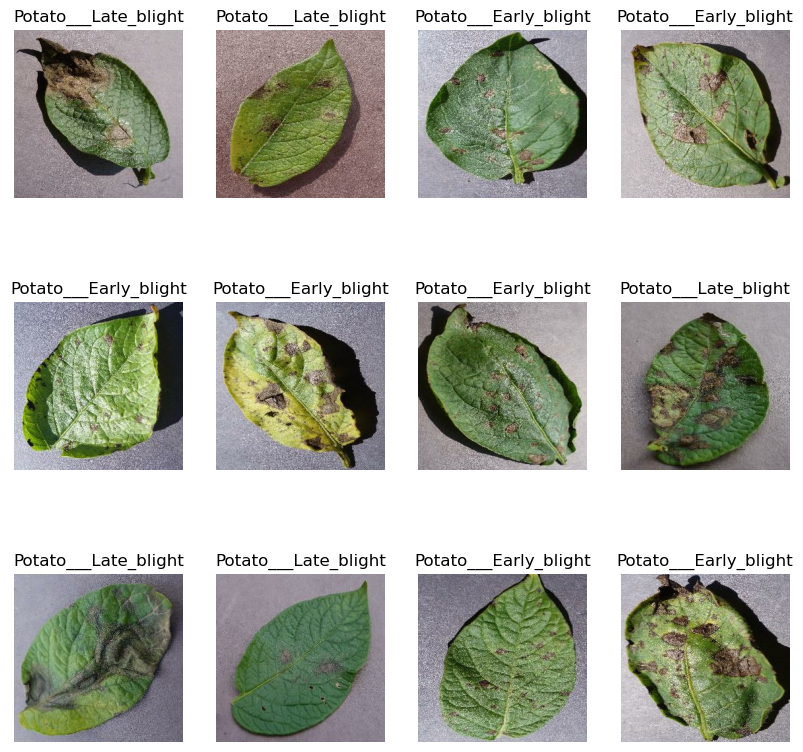

In [10]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [11]:
def get_data_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert train_split + val_split + test_split == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=44)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    test_size = int(ds_size * test_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_data_partitions(data)

In [13]:
len(data), len(train_ds), len(val_ds), len(test_ds)

(68, 54, 6, 8)

In [14]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255),
# ])

In [16]:
resize_and_rescale = tf.keras.models.Sequential()

resize_and_rescale.add(tf.keras.layers.Resizing(256, 256))
resize_and_rescale.add(tf.keras.layers.Rescaling(scale=1./255))

In [17]:
data_augmentation = tf.keras.models.Sequential()

data_augmentation.add(tf.keras.layers.RandomFlip())
data_augmentation.add(tf.keras.layers.RandomRotation(0.2))

In [18]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [19]:
n_classes = 3
INPUT_SHAPE = (32, 256, 256, 3)

In [20]:
model = tf.keras.models.Sequential()

model.add(resize_and_rescale)
model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

# model.add(tf.keras.layers.Conv2D(128, (3, 3), 1, activation = "relu"))
# model.add(tf.keras.layers.MaxPooling2D())

# model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation = "relu"))
# model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dense(n_classes, activation = "softmax"))


In [21]:
model.build(input_shape=INPUT_SHAPE)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 16)          0         
 g2D)                                                 

In [23]:
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)

In [24]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
hist = model.fit(train_ds, batch_size=32, validation_data = val_ds, epochs=20, callbacks=[es])

Epoch 1/20
54/54 [==============================] - 81s 1s/step - loss: 1.0608 - accuracy: 0.6491 - val_loss: 0.4811 - val_accuracy: 0.7865
Epoch 2/20
54/54 [==============================] - 79s 1s/step - loss: 0.4892 - accuracy: 0.7928 - val_loss: 0.5292 - val_accuracy: 0.7865
Epoch 3/20
54/54 [==============================] - 80s 1s/step - loss: 0.4186 - accuracy: 0.8163 - val_loss: 0.6571 - val_accuracy: 0.8021
Epoch 4/20
54/54 [==============================] - 81s 1s/step - loss: 0.3547 - accuracy: 0.8550 - val_loss: 0.3989 - val_accuracy: 0.8021
Epoch 5/20
54/54 [==============================] - 82s 1s/step - loss: 0.2502 - accuracy: 0.9002 - val_loss: 0.3791 - val_accuracy: 0.8571
Epoch 6/20
54/54 [==============================] - 84s 2s/step - loss: 0.2024 - accuracy: 0.9249 - val_loss: 0.3349 - val_accuracy: 0.8802
Epoch 7/20
54/54 [==============================] - 85s 2s/step - loss: 0.1761 - accuracy: 0.9407 - val_loss: 0.1436 - val_accuracy: 0.9583
Epoch 8/20
54/54 [==